In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from scipy import optimize

import torch
from torch import nn

from utils import get_gaussian_targets
from models import RNN
from train import test_and_get_stats, train_bptt, train_bptt_sparse
from viz import (plot_learning, plot_state_traj, plot_all_units,
                 plot_weight_distr)

In [2]:
# set meta-parameters
# for plotting style
custom_params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style='ticks', rc=custom_params)
# for pytorch tensors
device = 'cpu'
# for reproducibility while troubleshooting; numpy is for model sparse conns
torch.random.manual_seed(93214)
np.random.seed(35107)

In [3]:
# instantiate network
n_inputs, n_hidden, n_outputs = 1, 500, 10
model = RNN(n_inputs=n_inputs, n_hidden=n_hidden,
            n_outputs=n_outputs)

In [4]:
# set simulation parameters
dt = 1e-3  # 1 ms
tstop = 1.2  # 1 sec
times = np.arange(-0.1 + dt, tstop + dt, dt)
n_times = len(times)

# instantiate loss function and optimizer
mse_fn = nn.MSELoss()
loss_fn = lambda a, b: mse_fn(a, b) / (b ** 2).mean()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Bounds: tensor([0.0180, 0.9820])


/tmp/ipykernel_95977/2965935179.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


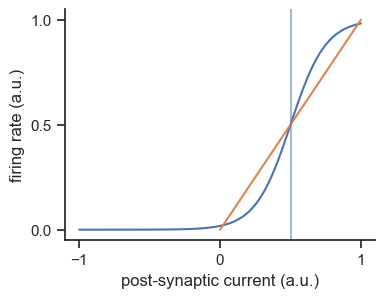

In [5]:
x = torch.linspace(-1, 1, 100)
fig, axes = plt.subplots(1, 1, figsize=(4, 3))
axes.plot(x, model.transfer_func(x,
                                 gain=model.activation_gain,
                                 thresh=model.activation_thresh))
axes.plot([0, 1], [0, 1])
axes.axvline(0.5, c='C0', alpha=0.5)
axes.set_xticks([-1, 0, 1])
axes.set_yticks([0, 0.5, 1])
axes.set_xlabel('post-synaptic current (a.u.)')
axes.set_ylabel('firing rate (a.u.)')
fig.show()
print(f'Bounds: {model.transfer_func(torch.tensor([0, 1]))}')

In [6]:
def adjust_gain_stp(model, n_steps=8):
    '''Adjust network gain to compensate for STP in-place.
    
    Returns initial gain value.
    '''

    # define inputs (for contextual modulation / recurrent perturbations)
    n_batches = 1
    inputs = torch.zeros((n_batches, n_times, n_inputs))
    perturb_dur = 0.05  # 50 ms
    perturb_win_mask = np.logical_and(times > -perturb_dur, times < 0)
    inputs[:, perturb_win_mask, :] = 0.1
    noise_tau = 0.01
    noise_std = 0.0

    # define output targets
    # set std s.t. amplitude decays to 1/e at intersection with next target
    targ_std = 0.05 / np.sqrt(2)  # ~35 ms
    # tile center of target delays spanning sim duration (minus margins)
    delay_times = np.linspace(0.1, 1.0, n_outputs)
    targets = get_gaussian_targets(n_batches, delay_times, times, targ_std)

    # set initial conditions of recurrent units fixed across iterations of
    # training and testing
    h_0 = torch.zeros(n_hidden)  # steady-state for postsyn activity var
    h_0 = torch.tile(h_0, (n_batches, 1))  # replicate for each batch
    r_0 = torch.ones(n_hidden)  # steady-state for depression var
    r_0 = torch.tile(r_0, (n_batches, 1))
    u_0 = model.p_rel.detach()  # steady-state for facilitation var
    u_0 = torch.tile(u_0, (n_batches, 1))

    # run opt routine
    # move to desired device
    inputs = inputs.to(device)
    targets = targets.to(device)
    h_0 = h_0.to(device)
    r_0 = r_0.to(device)
    u_0 = u_0.to(device)

    # move to desired device
    model.to(device)

    # (re)set gain to its baseline value
    model.gain = model._init_gain

    # slowly inclrease STP beta param, turning up gain adjustment accordingly
    beta_steps = torch.linspace(0, model.beta, n_steps + 1)
    gain_vals = list()
    model.eval()
    for beta in beta_steps:
        model.beta = beta
        
        # adjust beta twice for each incremental increase in beta
        for update_idx in range(2):
            state_vars_, _ = test_and_get_stats(inputs, targets, times,
                                                model, loss_fn, h_0, r_0, u_0,
                                                include_stp=True,
                                                noise_tau=noise_tau,
                                                noise_std=noise_std,
                                                plot=False)
            ext_in_, hidden_sr_t_, r_t_, u_t_, output_sr_t_ = state_vars_
            syn_eff_ = r_t_* u_t_
            adjustment_fctr = model.p_rel.mean() / syn_eff_.mean()
            model.gain = model._init_gain * adjustment_fctr
            gain_vals.append(model.gain.item())
    
    return gain_vals

Test loss: 6.154509
Test loss: 6.154509
Test loss: 6.395271
Test loss: 6.455763
Test loss: 5.996925
Test loss: 6.045248
Test loss: 5.179660
Test loss: 5.781995
Test loss: 5.223061
Test loss: 5.379426
Test loss: 5.682727
Test loss: 6.073446
Test loss: 5.418121
Test loss: 5.468586
Test loss: 5.252205
Test loss: 5.488106
Test loss: 4.943773
Test loss: 5.019568


/tmp/ipykernel_95977/30051353.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


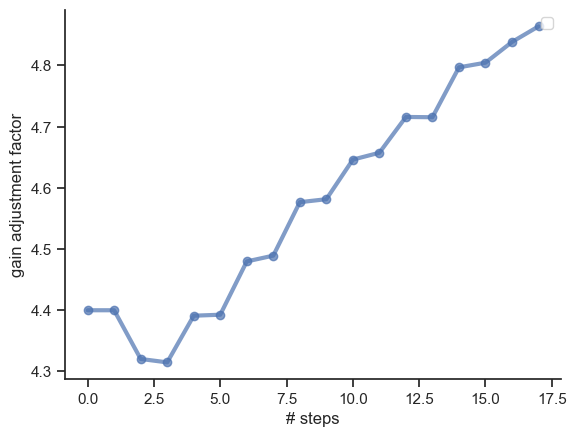

In [7]:
# run gain adjustment and save baseline and ajusted gain vals for later
gains = adjust_gain_stp(model, n_steps=8)
base_gain = gains[0]
adjusted_gain = gains[-1]

plt.figure()
plt.plot(range(len(gains)), gains, '-o', lw=3, alpha=0.7)
plt.xlabel('# steps')
plt.ylabel('gain adjustment factor')
plt.legend()
plt.show()

[-0.04117473  0.09835291  0.02588411 ...  0.87956341  0.77531506
  0.95053455] 3028 The solution converged.
0.0037884537869356206


/tmp/ipykernel_95977/401067678.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


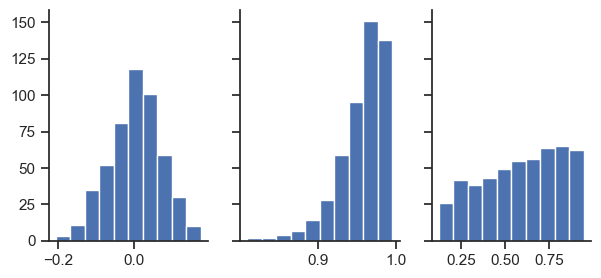

In [8]:
# find fixed point near low-state
# move to desired device
model.to(device)

# get fixed points
def func_roots(x):
    n_batches = 1
    x = torch.tensor(x, dtype=torch.float32)
    h_0 = x[:n_hidden]
    h_0 = torch.tile(h_0, (n_batches, 1))
    r_0 = x[n_hidden:2 * n_hidden]
    r_0 = torch.tile(r_0, (n_batches, 1))
    u_0 = x[2 * n_hidden:3 * n_hidden]
    u_0 = torch.tile(u_0, (n_batches, 1))
    inputs = torch.zeros((n_batches, 1, n_inputs))

    inputs = inputs.to(device)
    h_0 = h_0.to(device)
    r_0 = r_0.to(device)
    u_0 = u_0.to(device)

    model.eval()
    with torch.no_grad():
        dhdt, drdt, dudt = model(inputs, h_0=h_0, r_0=r_0, u_0=u_0, dt=dt,
                                 return_deriv=True, include_stp=True)

    return torch.concat((dhdt, drdt, dudt))

# set initial conditions of recurrent units fixed across iterations of
# training and testing
h_0 = torch.zeros(n_hidden)
r_0 = torch.ones(n_hidden)
u_0 = model.p_rel.detach()
x_0 = torch.concat((h_0, r_0, u_0))
sol = optimize.root(func_roots, x0=x_0, method='hybr')

print(sol.x, sol.nfev, sol.message)

# plot histograms for state variables across units in hidden layer
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(7, 3))
axes[0].hist(sol.x[:n_hidden])
# axes[0].set_xlim([-1, 1])
axes[1].hist(sol.x[n_hidden:2 * n_hidden])
# axes[1].set_xlim([0, 1])
axes[2].hist(sol.x[2 * n_hidden:3 * n_hidden])
# axes[2].set_xlim([0, 1])
fig.show()
print(sol.x[:n_hidden].mean())

In [9]:
# # define inputs
# include_stp = True
# n_batches = 1
# inputs = torch.zeros((n_batches, n_times, n_inputs))
# perturb_dur = 0.05  # 50 ms
# perturb_win_mask = np.logical_and(times > -perturb_dur, times < 0)
# inputs[:, perturb_win_mask, :] = 0.1
# noise_tau = 0.01
# noise_std = 1e-6

# # define output targets
# # set std s.t. amplitude decays to 1/e at intersection with next target
# targ_std = 0.05 / np.sqrt(2)  # ~35 ms
# # tile center of target delays spanning sim duration (minus margins)
# delay_times = np.linspace(0.1, 1.0, n_outputs)
# targets = get_gaussian_targets(n_batches, delay_times, times, targ_std)

# # set initial conditions of recurrent units fixed across iterations of
# # training and testing
# # h_0 = torch.tensor(sol.x[:n_hidden], dtype=torch.float32)
# h_0 = torch.zeros(n_hidden)
# h_0 = torch.tile(h_0, (n_batches, 1))  # replicate for each batch
# # r_0 = torch.tensor(sol.x[n_hidden:2 * n_hidden], dtype=torch.float32)
# r_0 = torch.ones(n_hidden) 
# r_0 = torch.tile(r_0, (n_batches, 1))
# # u_0 = torch.tensor(sol.x[2 * n_hidden:3 * n_hidden], dtype=torch.float32)
# u_0 = model.p_rel.detach()
# u_0 = torch.tile(u_0, (n_batches, 1))

# # run opt routine
# # move to desired device
# inputs = inputs.to(device)
# targets = targets.to(device)
# h_0 = h_0.to(device)
# r_0 = r_0.to(device)
# u_0 = u_0.to(device)

# # plot model output before training
# _, sim_stats_pre = test_and_get_stats(inputs, targets, times,
#                                       model, loss_fn, h_0, r_0, u_0,
#                                       include_stp=include_stp,
#                                       noise_tau=noise_tau,
#                                       noise_std=noise_std,
#                                       plot=True)

# weights_pre = model.gain * model.W_hh * model.presyn_scaling.detach()
# w_out_pre = model.W_hz.detach()

# # train model weights
# max_iter = 200
# loss_per_iter = list()
# for iter_idx in range(max_iter):
#     loss = train_bptt(inputs, targets, times, model, loss_fn, optimizer,
#                       h_0, r_0, u_0, dt=dt, include_stp=include_stp,
#                       noise_tau=noise_tau, noise_std=noise_std)
#     loss_per_iter.append(loss)
#     print(f"Training trial {iter_idx} complete!")

# weights_post = model.gain * model.W_hh * model.presyn_scaling.detach()
# w_out_post = model.W_hz.detach()

# # investigate fitted model
# # plot model output after training
# state_vars_post, sim_stats_post = test_and_get_stats(
#     inputs, targets, times, model, loss_fn, h_0, r_0, u_0,
#     include_stp=include_stp, noise_tau=noise_tau, noise_std=noise_std,
#     plot=True)

# ext_in_post, hidden_sr_post, r_post, u_post, output_sr_post = state_vars_post
# loss_per_iter.append(sim_stats_post['loss'])

# # plot loss across training
# fig_learning = plot_learning(np.array(loss_per_iter), max_iter=None)
# # plt.savefig('/home/ryan/Desktop/training_loss_force.png')

In [10]:
def train_net(model, optimizer, loss_fn, times,
              tau, include_stp, noise_tau, noise_std, include_corr_noise,
              adjusted_gain,
              n_trials=1000, return_trials=(0, 100, 1000), device='cpu'):
    '''Train current instantiation of network model.
    
    Returns network parameters and variables after return_trials number of
    training trials.
    '''

    # define inputs
    n_batches = 1
    n_inputs = model.n_inputs
    n_hidden = model.n_hidden
    n_outputs = model.n_outputs
    n_times = len(times)
    inputs = torch.zeros((n_batches, n_times, n_inputs))
    perturb_dur = 0.05  # 50 ms
    perturb_win_mask = np.logical_and(times > -perturb_dur, times < 0)
    inputs[:, perturb_win_mask, :] = 0.1

    model.tau = tau
    if model.tau > 0.01:
        # increase input strength
        inputs[:, perturb_win_mask, :] = 0.3
    if include_stp:
        model.gain = adjusted_gain
    else:
        model.gain = model._init_gain

    # define output targets
    # set std s.t. amplitude decays to 1/e at intersection with next target
    targ_std = 0.05 / np.sqrt(2)  # ~35 ms
    # tile center of target delays spanning sim duration (minus margins)
    delay_times = np.linspace(0.1, 1.0, n_outputs)
    targets = get_gaussian_targets(n_batches, delay_times, times, targ_std)

    # set initial conditions of recurrent units fixed across iterations of
    # training and testing
    # h_0 = torch.tensor(sol.x[:n_hidden], dtype=torch.float32)
    h_0 = torch.zeros(n_hidden)
    h_0 = torch.tile(h_0, (n_batches, 1))  # replicate for each batch
    # r_0 = torch.tensor(sol.x[n_hidden:2 * n_hidden], dtype=torch.float32)
    r_0 = torch.ones(n_hidden) 
    r_0 = torch.tile(r_0, (n_batches, 1))
    # u_0 = torch.tensor(sol.x[2 * n_hidden:3 * n_hidden], dtype=torch.float32)
    u_0 = model.p_rel.detach()
    u_0 = torch.tile(u_0, (n_batches, 1))

    # run opt routine
    # move to desired device
    inputs = inputs.to(device)
    targets = targets.to(device)
    h_0 = h_0.to(device)
    r_0 = r_0.to(device)
    u_0 = u_0.to(device)

    optimizer.zero_grad()

    # train model weights
    losses = list()
    params = list()
    state_vars = list()
    for trial_idx in range(n_trials):

        loss, init_params, state_vars_raw  = train_bptt(
            inputs, targets, times, model, loss_fn,
            optimizer, h_0, r_0, u_0, dt=dt,
            include_stp=include_stp, noise_tau=noise_tau,
            noise_std=noise_std)

        if trial_idx in return_trials:
            params.append(init_params)
            ext_in, h_t, r_t, u_t, z_t = state_vars_raw
            state_vars_processed = (ext_in.detach().numpy(),
                                    model.transfer_func(h_t).detach().numpy(),
                                    r_t.detach().numpy(),
                                    u_t.detach().numpy(),
                                    z_t.detach().numpy())
            state_vars.append(state_vars_processed)

        losses.append(loss)
        print(f"Training trial {trial_idx} complete!")

    # investigate fitted model after training; test output using iid noise
    # averaged across 10 trials
    inputs_test = torch.tile(inputs, dims=(10, 1, 1))
    targets_test = torch.tile(targets, dims=(10, 1, 1))
    h_0_test = torch.tile(h_0, dims=(10, 1))
    r_0_test = torch.tile(r_0, dims=(10, 1))
    u_0_test = torch.tile(u_0, dims=(10, 1))
    state_vars_post_raw, sim_stats_post = test_and_get_stats(
        inputs_test, targets_test, times, model, loss_fn,
        h_0_test, r_0_test, u_0_test,
        include_stp=include_stp, noise_tau=noise_tau, noise_std=noise_std,
        plot=True)

    losses.append(sim_stats_post['loss'])

    if trial_idx + 1 in return_trials:
        final_params = [param.detach().numpy() for param in model.parameters()
                        if param.requires_grad]
        params.append(final_params)

        ext_in, h_t, r_t, u_t, z_t = state_vars_post_raw
        state_vars_post_processed = (ext_in.detach().numpy(),
                                     model.transfer_func(h_t).detach().numpy(),
                                     r_t.detach().numpy(),
                                     u_t.detach().numpy(),
                                     z_t.detach().numpy())
        state_vars.append(state_vars_post_processed)
    
    return losses, params, state_vars

In [11]:
sim_params_all = [[0.01, False, 0.01, 0.0, False],
                  [0.05, False, 0.01, 0.0, False],
                  [0.01, False, 0.01, 0.0, False],
                  [0.01, True, 0.01, 0.0, False],
                  [0.01, False, 0.01, 1e-6, False],
                  [0.01, True, 0.01, 1e-6, False],
                  [0.01, False, 0.01, 1e-6, True],
                  [0.01, True, 0.01, 1e-6, True]]

Training trial 0 complete!
Training trial 1 complete!
Training trial 2 complete!
Training trial 3 complete!
Training trial 4 complete!
Test loss: 1.245838


/home/ryan/time_coding/train.py:253: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


ValueError: could not broadcast input array from shape (3,10) into shape (3,10,500)

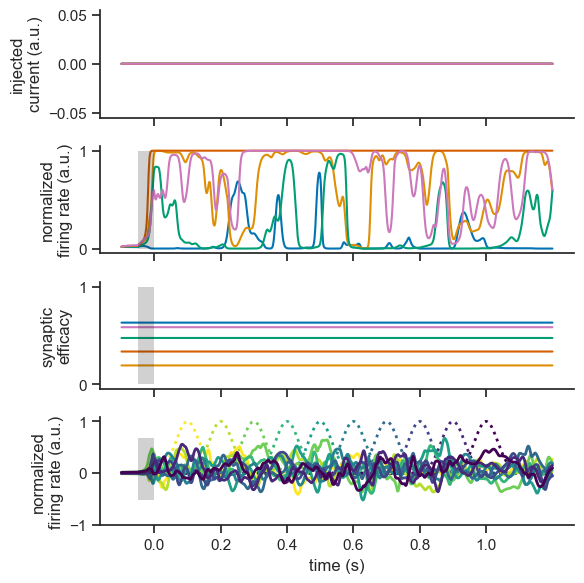

In [26]:
n_trials = 5
return_trials = (0, 2, 5)

init_W_hz = model.W_hz.data.detach()
init_offset_hz = model.offset_hz.data.detach()

n_sims = len(sim_params_all)
n_return_trials = len(return_trials)
n_vars = 5
n_model_params = 2
n_batches = 1
losses_all = np.empty((n_sims, n_trials + 1), dtype=np.float32)
model_params_all = {'W_hz': np.empty((n_sims, n_return_trials, n_outputs, n_hidden),
                                     dtype=np.float32),
                    'offset_hz': np.empty((n_sims, n_return_trials, n_outputs, n_hidden),
                                     dtype=np.float32)}
state_vars_all = {'ext_in': np.empty((n_sims, n_return_trials, n_batches, n_times, n_hidden),
                                     dtype=np.float32),
                  'h_t': np.empty((n_sims, n_return_trials, n_batches, n_times, n_hidden),
                                  dtype=np.float32),
                  'r_t': np.empty((n_sims, n_return_trials, n_batches, n_times, n_hidden),
                                  dtype=np.float32),
                  'u_t': np.empty((n_sims, n_return_trials, n_batches, n_times, n_hidden),
                                  dtype=np.float32),
                  'z_t': np.empty((n_sims, n_return_trials, n_batches, n_times, n_outputs),
                                  dtype=np.float32)}
                      

for sim_idx, sim_params in enumerate(sim_params_all):
     tau, include_stp, noise_tau, noise_std, include_corr_noise = sim_params

     # reset output weights
     with torch.no_grad():
          model.W_hz.copy_(init_W_hz)
          model.offset_hz.copy_(init_offset_hz)

     losses, model_params, state_vars = train_net(
          model=model,
          optimizer=optimizer,
          loss_fn=loss_fn,
          times=times,
          tau=tau,
          include_stp=include_stp,
          noise_tau=noise_tau,
          noise_std=noise_std,
          include_corr_noise=include_corr_noise,
          adjusted_gain=adjusted_gain,
          n_trials=n_trials,
          return_trials=return_trials,
          device=device)

     losses_all[sim_idx, :] = losses
     # convert to ragged array, then parse according to parameter name
     # model_params = np.array(model_params, dtype=object)
     model_params_all['W_hz'][sim_idx] = np.array([model_param[0] for model_param in model_params])
     model_params_all['offset_hz'][sim_idx] = np.array([model_param[1] for model_param in model_params])
     # convert to ragged array, then parse according to variable name
     state_vars = np.array(state_vars, dtype=object)
     state_vars_all['ext_in'][sim_idx] = np.array(state_vars[:, 0])
     state_vars_all['h_t'][sim_idx] = np.array(state_vars[:, 1])
     state_vars_all['r_t'][sim_idx] = np.array(state_vars[:, 2])
     state_vars_all['u_t'][sim_idx] = np.array(state_vars[:, 3])
     state_vars_all['z_t'][sim_idx] = np.array(state_vars[:, 4])

In [24]:
foo = np.array(model_params, dtype=object)

ValueError: could not broadcast input array from shape (10,500) into shape (10,)

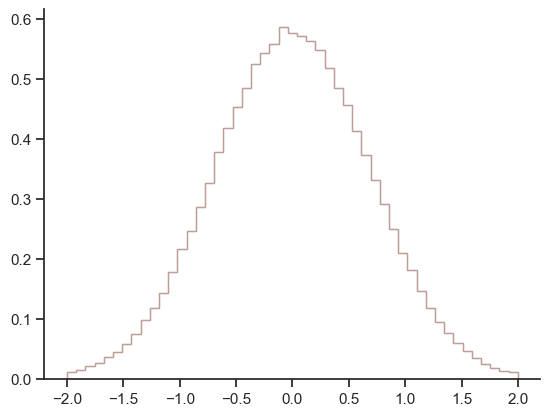

In [ ]:
bins = np.linspace(-2, 2, 30)

fig = plt.figure()
plt.hist(w_out_pre.detach().flatten(), bins=bins, density=True, histtype='step', fill=False, alpha=0.5)
plt.hist(w_out_post.detach().flatten(), bins=bins, density=True, histtype='step', fill=False, alpha=0.5)
# plt.hist(weights_post.detach().flatten() - weights_pre.detach().flatten(), bins=bins, density=True, histtype='step', fill=False)
plt.show()

In [ ]:
def f_prime(x, gain=8.0, thresh=0.5):
    exp_term = torch.exp(-gain * (x - thresh))
    return gain * exp_term / (1 + exp_term) ** 2

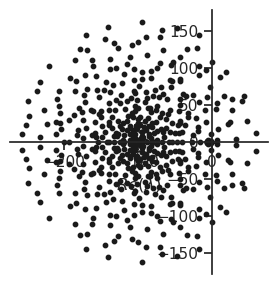

In [ ]:
angles = np.linspace(0, 2 * np.pi, 100)
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(7, 3))

h_0 = torch.tensor(sol.x[:n_hidden], dtype=torch.float32)
r_0 = torch.tensor(sol.x[n_hidden:2 * n_hidden], dtype=torch.float32)
u_0 = torch.tensor(sol.x[2 * n_hidden:3 * n_hidden], dtype=torch.float32)

jacobian_h = torch.cat((
    (-torch.eye(model.n_hidden) + weights_pre * r_0 * u_0 * f_prime(h_0)) / model.tau,
    weights_pre * u_0 * model.transfer_func(h_0) / model.tau,
    weights_pre * r_0 * model.transfer_func(h_0) / model.tau
), dim=1)

jacobian_r = torch.cat((
    torch.diag(-model.beta * r_0 * u_0 * f_prime(h_0)),
    torch.diag(-(1 / model.tau_depr + model.beta * u_0 * model.transfer_func(h_0))),
    torch.diag(-model.beta * r_0 * model.transfer_func(h_0))
), dim=1)

jacobian_u = torch.cat((
    torch.diag(model.beta * model.p_rel * (1 - u_0) * f_prime(h_0)),
    torch.zeros((model.n_hidden, model.n_hidden)),
    torch.diag(-(1 / model.tau_facil + model.beta * model.p_rel * model.transfer_func(h_0)))
), dim=1)

jacobian_full = torch.cat((jacobian_h, jacobian_r, jacobian_u), dim=0)
eigvals_0, eigvecs_0 = scipy.linalg.eig(jacobian_full)
# ax.axvline(0, c='r')
ax.scatter(eigvals_0.real, eigvals_0.imag, c='k', s=10)
# ax.set_title('pre-training')
# ax.set_xticks([])
ax.set_xlabel(r'$Re(\lambda)$')
# ax.set_yticks([])
ax.set_ylabel(r'$Im(\lambda)$')

ax.set_aspect('equal')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
fig.tight_layout()

(array([  0.,   0.,   0.,   0.,   0.,   6.,   3.,   9.,  14.,   6.,  14.,
         12.,  25.,  11.,  23.,  24.,  22.,  24.,  23.,  38.,  27.,  29.,
         24.,  23.,  16.,  29.,  11.,  16.,  17.,  12.,  12.,   9.,  13.,
          4.,   2.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 500.,   0.,   0.,   0.,   0., 500.]),
 array([-120., -119., -118., -117., -116., -115., -114., -113., -112.,
        -111., -110., -109., -108., -107., -106., -105., -104., -103.,
        -102., -101., -100.,  -99.,  -98.,  -97.

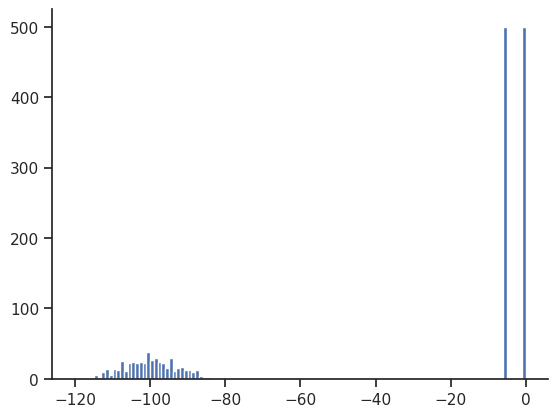

In [ ]:
eigvals_real_sorted = np.sort(eigvals_0.real)
plt.figure()
plt.hist(eigvals_real_sorted, bins=np.linspace(-120, 0, 121))

In [ ]:
# weights = model.W_hh * model.presyn_scaling.detach() * model.p_rel
angles = np.linspace(0, 2 * np.pi, 100)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(7, 3))

jacobian_0 = (weights_pre * f_prime(0) * model.p_rel - torch.eye(model.n_hidden)) / model.tau
eigvals_0, eigvecs_0 = scipy.linalg.eig(jacobian_0)
# ax[0].plot(np.cos(angles)-1, np.sin(angles), 'r')
ax[0].scatter(eigvals_0.real, eigvals_0.imag, c='k', s=10)
ax[0].set_title('pre-training')

jacobian_1 = (weights_post * f_prime(0) * model.p_rel - torch.eye(model.n_hidden)) / model.tau
eigvals_1, eigvecs_1 = scipy.linalg.eig(jacobian_1)
# ax[1].plot(np.cos(angles)-1, np.sin(angles), 'r')
ax[1].scatter(eigvals_1.real, eigvals_1.imag, c='k', s=10)
ax[1].set_title('post-training')

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

ax[0].spines['left'].set_position('zero')
ax[0].spines['bottom'].set_position('zero')
ax[1].spines['left'].set_position('zero')
ax[1].spines['bottom'].set_position('zero')
ax[1].set_yticks([])
ax[1].set_xticks([])

SyntaxError: invalid syntax (2722753663.py, line 11)

In [ ]:
sim_stats_pre['dimensionality']

3.3300537560216683

In [ ]:
sim_stats_post['dimensionality']

3.714206065600773

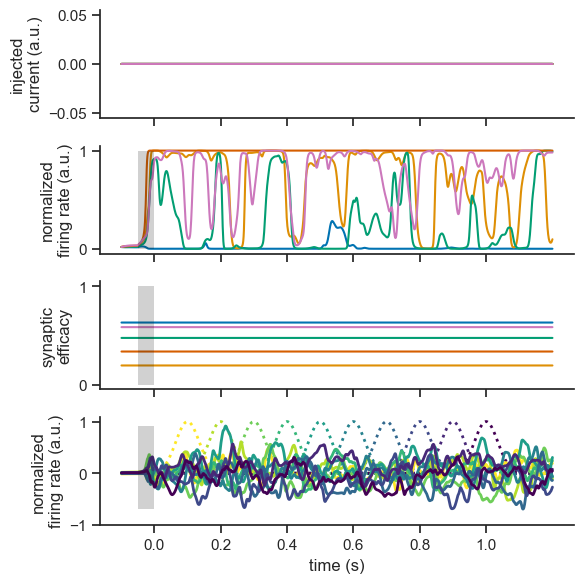

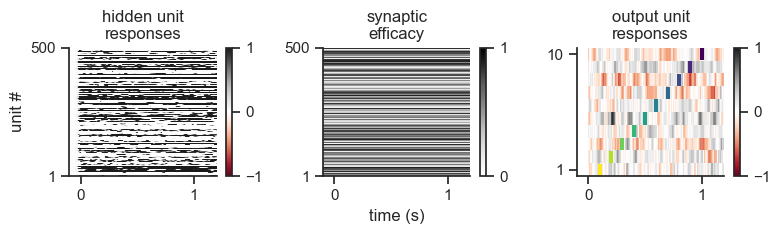

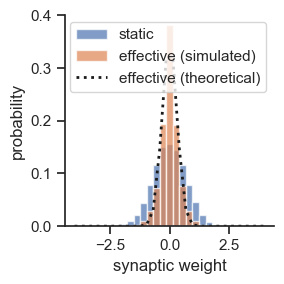

In [ ]:
# plot sim of current model
model.eval()

with torch.no_grad():
    ext_in, h_t, r_t, u_t, z_t = model(inputs, h_0=h_0, r_0=r_0, u_0=u_0,
                                       dt=dt, include_stp=False)

weights = model.W_hh * model.presyn_scaling.detach()
prob_c = float(torch.count_nonzero(model.W_hh_mask) /
               torch.numel(model.W_hh_mask))

# select first batch if more than one exists
noise_batch = ext_in.cpu()[0] - inputs.cpu()[0]
hidden_batch = model.transfer_func(h_t).cpu()[0]
syn_eff_batch = r_t.cpu()[0] * u_t.cpu()[0]
outputs_batch = z_t.cpu()[0]
targets_batch = targets.cpu()[0]

fig_traj = plot_state_traj(perturb=noise_batch, h_units=hidden_batch,
                           outputs=outputs_batch,
                           syn_eff=syn_eff_batch,
                           targets=targets_batch, times=times)

fig_all_units = plot_all_units(h_units=hidden_batch, syn_eff=syn_eff_batch,
                               outputs=outputs_batch,
                               targets=targets_batch, times=times)

fig_weights_distr = plot_weight_distr(weights, model.W_hh_mask,
                                      syn_eff_batch,
                                      eff_gain=2.2,
                                      true_gain=model.gain.detach(),
                                      prob_c=prob_c)
plt.show()

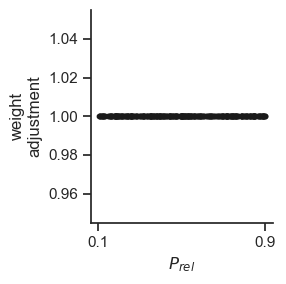

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(3, 3))
# sort_idxs = np.argsort(model.p_rel.detach().numpy())
p_rel = model.p_rel.detach().numpy()
post_syn_adjustment = model.presyn_scaling.detach().numpy()
axes.scatter(p_rel, post_syn_adjustment, s=10, c='k')
axes.set_xticks([0.1, 0.9])
axes.set_xlabel('$P_{rel}$')

# axes.set_yticks([0, np.max(post_syn_adjustment).round(decimals=1)])
axes.set_ylabel('weight\nadjustment')
fig.tight_layout()

In [ ]:
fig_traj.savefig('/home/ryan/Desktop/traj_gain_scaled_hz_nonforce_postlearning.png')
fig_all_units.savefig('/home/ryan/Desktop/units_all_gain_scaled_hz_nonforce_postlearning.png')
fig_weights_distr.savefig('/home/ryan/Desktop/hidden_weights_gain_scaling_postlearning.png')